In [41]:
# Importing necessary libraries

# For data manipulation
import re
import pickle
import numpy as np
import pandas as pd
import glob

# For EDA and visualization
import seaborn as sns
sns.set(rc={'figure.figsize': (20,10)})
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff


# For pre-processing text
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from better_profanity import profanity
profanity.load_censor_words()

# For other output and NLP utilities
from bokeh.plotting import figure
from bokeh.io import output_file, show, output_notebook
from collections import Counter
import spacy
from spacy.util import compounding
from spacy.util import minibatch
from spacy import displacy
import gc
import os
import urllib
import csv
from tqdm import tqdm

# For modelling and sentiment analysis
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/niharjoshi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data preparation

## Dataset initialization

#### Note: the total dataset size is 17 GB and cannot be processed without a GPU so for the sake of demonstration, we will use a subset of the data

In [2]:
# Loading all CSV files from the data/ folder
l = [pd.read_csv(filename, index_col=0, compression='gzip', low_memory=False) for filename in glob.glob("../data/input/*.gzip")]

# Combining all CSV files into a single dataframe
df = pd.concat(l, axis=0)

In [3]:
df.head()

userid       username  \
1858647  1316365168322977792   Mhiztawayne7   
1858648           2612807188   fleurdelis30   
1858649            567289542  Saudi_Gazette   
1858650             22763833   Outlookindia   
1858651  1269446109467901952  Themoneypost_   

                                                  acctdesc          location  \
1858647  Hustle👍, Hustle👍, Hustle👍 and Hustle👍 more, ma...     United States   
1858648  Research on 🇨🇦’s Koch: #AureaFoundation #munkd...  Montréal, Québec   
1858649  Saudi Gazette is a leading English language da...      Saudi Arabia   
1858650          The fully loaded news magazine from India  New Delhi, India   
1858651                    Noticias de economía y negocios        Costa Rica   

         following  followers  totaltweets               usercreatedts  \
1858647       1756        780        16804  2020-10-14 13:08:28.000000   
1858648       1428       1419       216017  2014-06-16 00:36:12.000000   
1858649          2     381484       126162  2012-04-30 13:01:28.000000   
1858650        183     237597       419566  2009-03-04 12:45:00.000000   
1858651          4         35        13654  2020-06-07 01:48:56.000000   

                     tweetid       tweetcreatedts  retweetcount  \
1858647  1499897477369151492  2022-03-05 00:00:00             1   
1858648  1499897477570469896  2022-03-05 00:00:00           324   
1858649  1499897478207795204  2022-03-05 00:00:00             0   
1858650  1499897478220754949  2022-03-05 00:00:00             0   
1858651  1499897478274945027  2022-03-05 00:00:00             0   

                                                      text  \
1858647  #Putin has the 'nudes' of EU power house count...   
1858648  Supermarkets removing #Russian food and drinks...   
1858649  The war in #Ukraine is "a catastrophe" for the...   
1858650  #OutlookBusiness | Exclusion of #Russian banks...   
1858651  Ucrania y Rusia también libran una criptoguerr...   

                                                  hashtags language  \
1858647  [{'text': 'Putin', 'indices': [13, 19]}, {'tex...       en   
1858648         [{'text': 'Russian', 'indices': [42, 50]}]       en   
1858649         [{'text': 'Ukraine', 'indices': [11, 19]}]       en   
1858650  [{'text': 'OutlookBusiness', 'indices': [0, 16...       en   
1858651  [{'text': 'TheMoneyPost', 'indices': [109, 122...       es   

        coordinates  favorite_count                 extractedts  
1858647         NaN               0  2022-03-05 00:04:02.554311  
1858648         NaN               0  2022-03-05 00:04:02.538168  
1858649         NaN               0  2022-03-05 00:04:02.520470  
1858650         NaN               0  2022-03-05 00:04:02.495538  
1858651         NaN               0  2022-03-05 00:04:02.479373

## Data cleaning

In [4]:
df.shape

(14353930, 17)

In [5]:
# Checking column datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14353930 entries, 1858647 to 140383
Data columns (total 17 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   userid          int64 
 1   username        object
 2   acctdesc        object
 3   location        object
 4   following       int64 
 5   followers       int64 
 6   totaltweets     int64 
 7   usercreatedts   object
 8   tweetid         int64 
 9   tweetcreatedts  object
 10  retweetcount    int64 
 11  text            object
 12  hashtags        object
 13  language        object
 14  coordinates     object
 15  favorite_count  int64 
 16  extractedts     object
dtypes: int64(7), object(10)
memory usage: 1.9+ GB


In [6]:
# Checking for empty values
df.isna().sum().sort_values(ascending=False)

coordinates       14347841
location           5946803
acctdesc           3126666
userid                   0
retweetcount             0
favorite_count           0
language                 0
hashtags                 0
text                     0
tweetid                  0
tweetcreatedts           0
username                 0
usercreatedts            0
totaltweets              0
followers                0
following                0
extractedts              0
dtype: int64

In [7]:
# Removing profanity from tweet texts
# df['text'] = df['text'].apply(lambda x: profanity.censor(x))

#### Since one of the steps in our EDA process is to check tweets by location, we need to handle empty location values

In [8]:
# Handling NaN values for location
df = df.dropna(subset=['location'])

# EDA

### Tweets by language

In [9]:
# Getting top 5 languages for tweets
df.language.value_counts()[:5]

en     5798608
de      389108
fr      387065
und     364123
it      295544
Name: language, dtype: int64

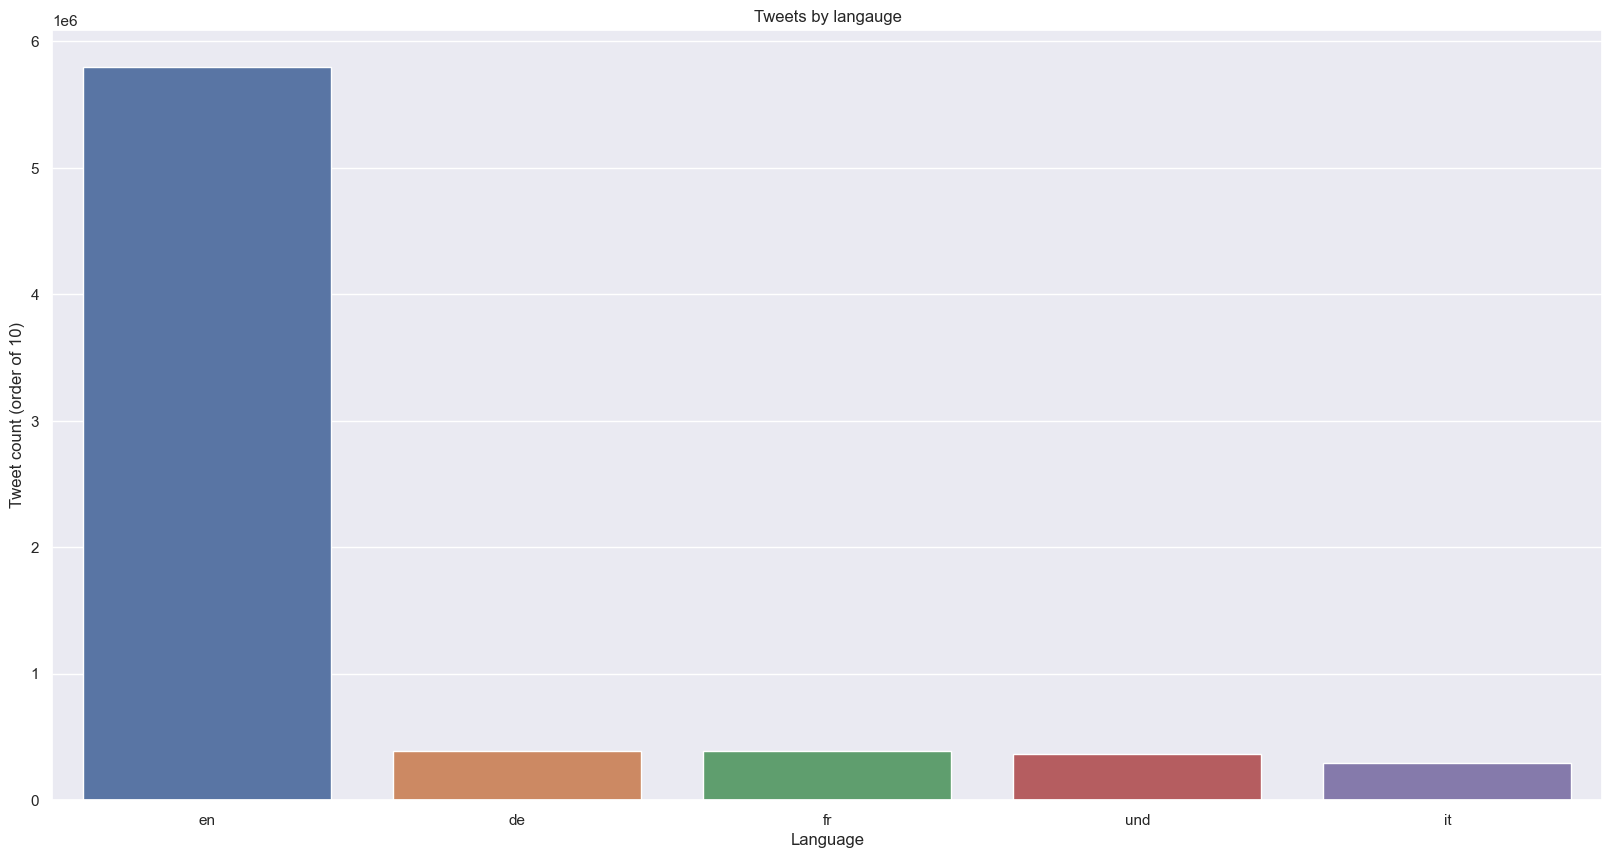

In [10]:
# Plotting barplot for visualization
fig = sns.barplot(x=df.language.value_counts()[:5].index, y=df.language.value_counts()[:5])
fig.set(title='Tweets by langauge', xlabel='Language', ylabel='Tweet count (order of 10)')
fig = fig.get_figure()

# Saving barplot to file
fig.savefig('../static/tweets_by_language.png', bbox_inches='tight')

#### For sentiment analysis, we will only be using tweets in English

In [11]:
# Extracting all tweets in English language
df_en = df[df.language == 'en'].drop('language', axis=1)

#### We will sort the tweets based on retweet count to judge for popularity

In [12]:
# Sorting tweets based on retweet count
sorted_tweets = df_en[['username', 'text', 'retweetcount', 'tweetid']].sort_values(by='retweetcount', ascending=False).reset_index()

# Getting top 10 most retweeted tweets
sorted_tweets[['username', 'text']].head(10)

username                                               text
0     CaptainToney  If only Bradley's arm was longer. Best photo e...
1  AgricultureEagl  We're kicking off 2018 with a worldwide givewa...
2       adamo_amor  .@ZelenskyyUa's tv address to the Russian (!) ...
3      Doktor_Nein  .@ZelenskyyUa's tv address to the Russian (!) ...
4  HarveyJ02354520  .@ZelenskyyUa's tv address to the Russian (!) ...
5  quietdilettant1  .@ZelenskyyUa's tv address to the Russian (!) ...
6    Chamberslmayo  .@ZelenskyyUa's tv address to the Russian (!) ...
7         akraschi  .@ZelenskyyUa's tv address to the Russian (!) ...
8       kian_renzo  .@ZelenskyyUa's tv address to the Russian (!) ...
9  DiscoHouseChic1  .@ZelenskyyUa's tv address to the Russian (!) ...

### Conversation topics and most used words

In [13]:
# Building stopwords set
stopwords_set = set(STOPWORDS)
stopwords_set = set(stopwords.words('english'))

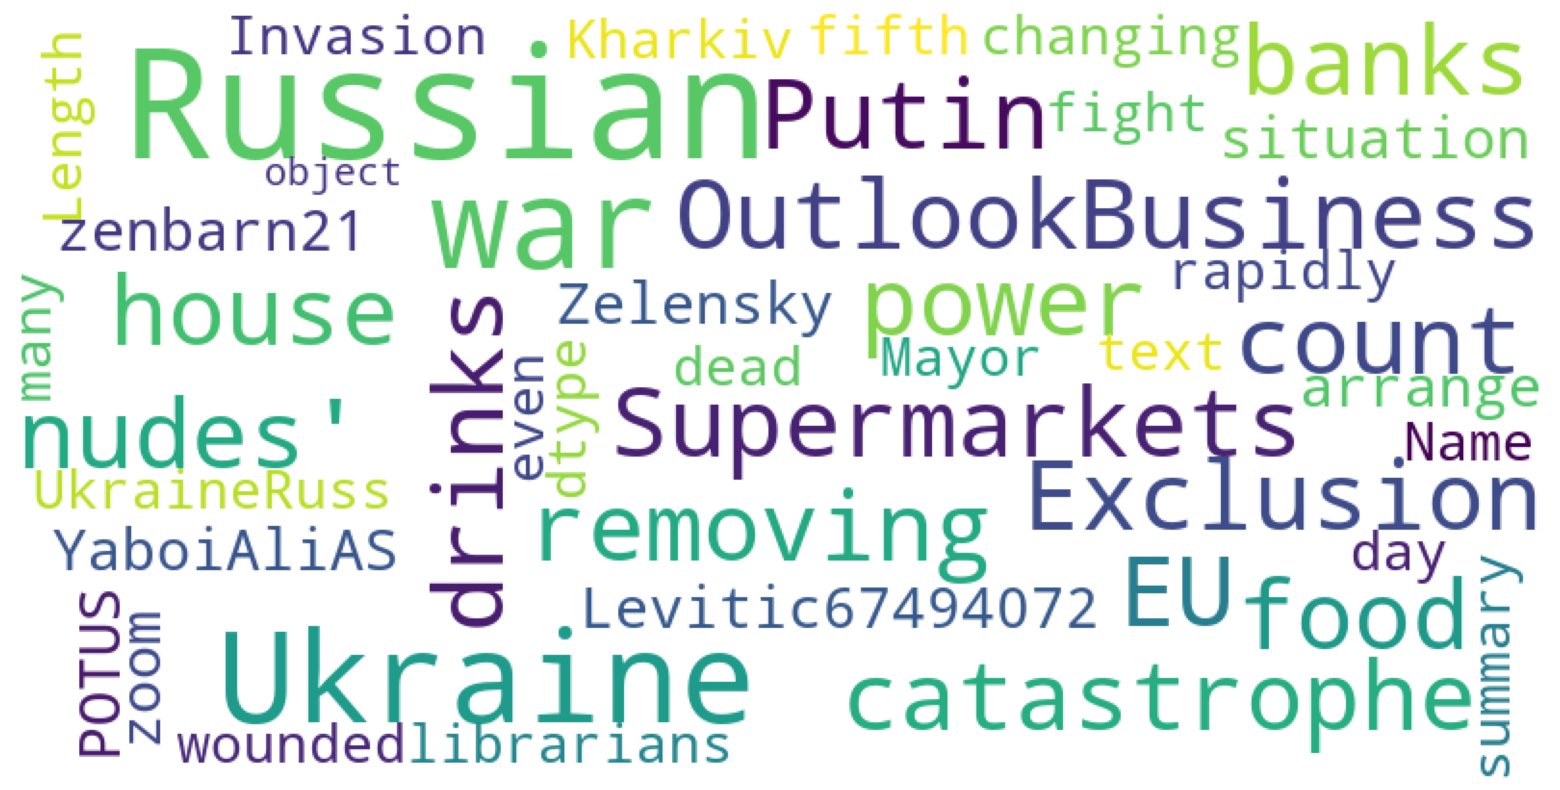

In [14]:
# Generating word cloud
wordcloud = WordCloud(background_color='white',
                      stopwords=stopwords_set,
                      max_words=300,
                      max_font_size=40,
                      scale=2,
                      random_state=42)
wordcloud.generate(str(df_en['text']))

# Displaying and saving word cloud
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('../static/top_conversation_topics_wordcloud.png')
plt.show()

#### Since a few tweets were retweeted too many times, it seems like a better idea to build a word cloud from only unique tweets

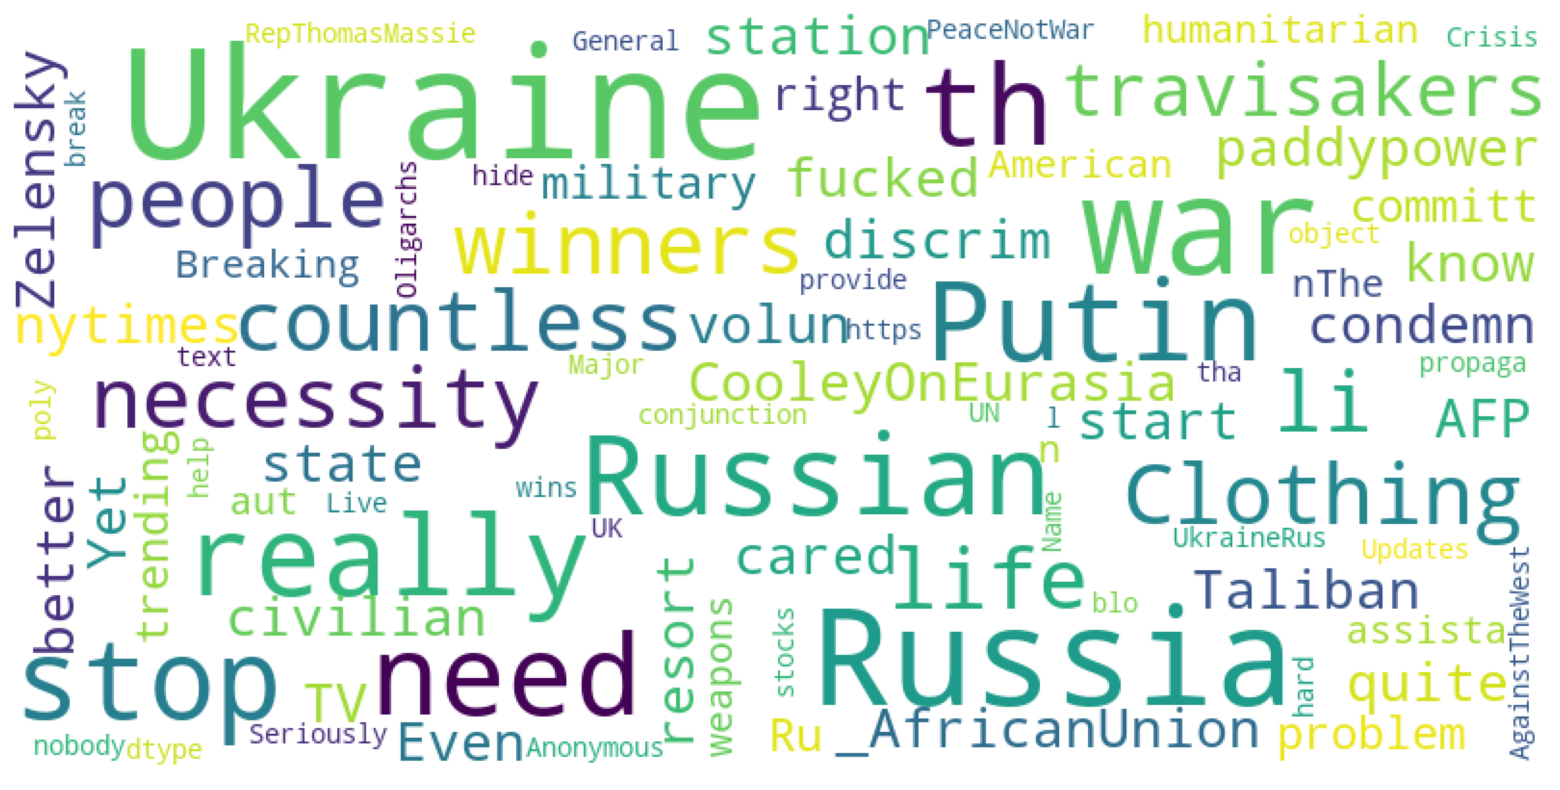

In [15]:
# Getting unique tweets
unique_tweets = df_en.drop_duplicates(subset=['text'])

# Building word cloud
wordcloud= WordCloud(background_color='white',
                    stopwords=stopwords_set,
                    max_words=300,
                    max_font_size=40,
                    scale=2,
                    random_state=42
                    ).generate(str(unique_tweets.sort_values(by='retweetcount').iloc[:20]['text']))

# Displaying and saving word cloud
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('../static/top_unique_conversation_topics_wordcloud.png')
plt.show()

### Tweets by location

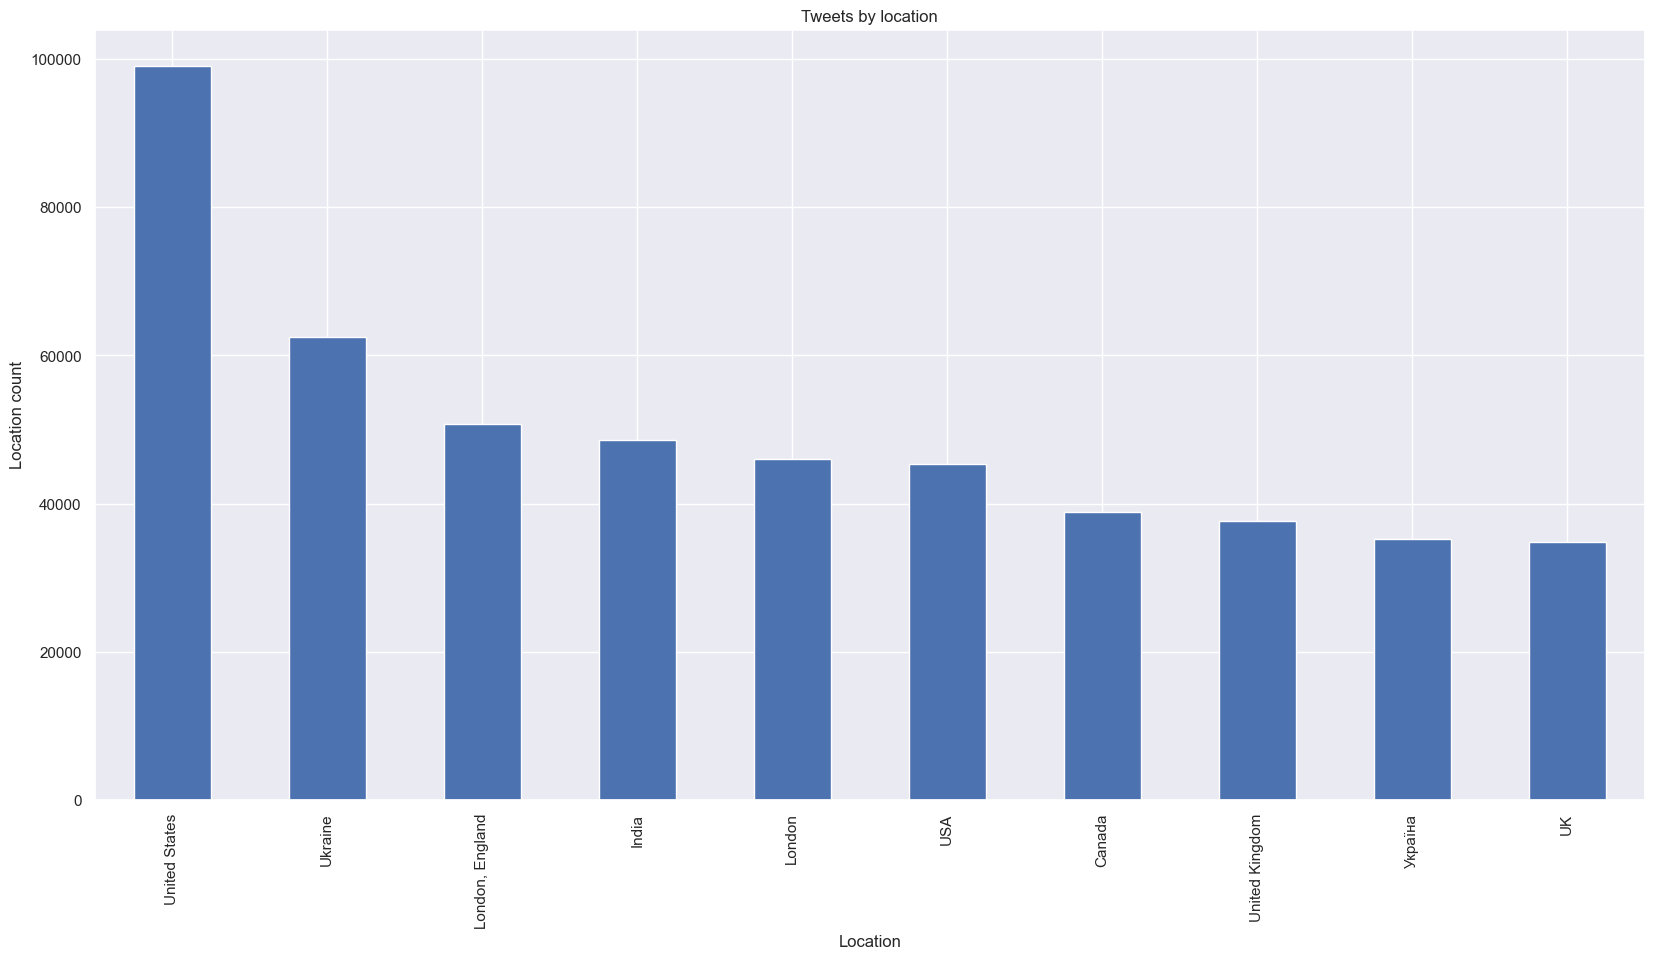

In [16]:
# Plotting barplot for visualization
fig = df_en.location.value_counts()[:10].plot.bar()
fig.set(title='Tweets by location', xlabel='Location', ylabel='Location count')
fig = fig.get_figure()

# Saving barplot to file
fig.savefig('../static/tweets_by_location.png', bbox_inches='tight')

### One of the points discussed during the project proposal was to check for tweets by new accounts and check for possible propaganda

#### Let's extract tweets by newest accounts and check how the wordcloud changes

In [17]:
time_cols = ['extractedts', 'tweetcreatedts', 'usercreatedts']

# Converting "user account created time" column to datetime
df_en['usercreatedts'] = pd.to_datetime(df_en['usercreatedts'])

# Sorting by youngest user account age
sort_by_userage= df_en.sort_values(by='usercreatedts', ascending=True)

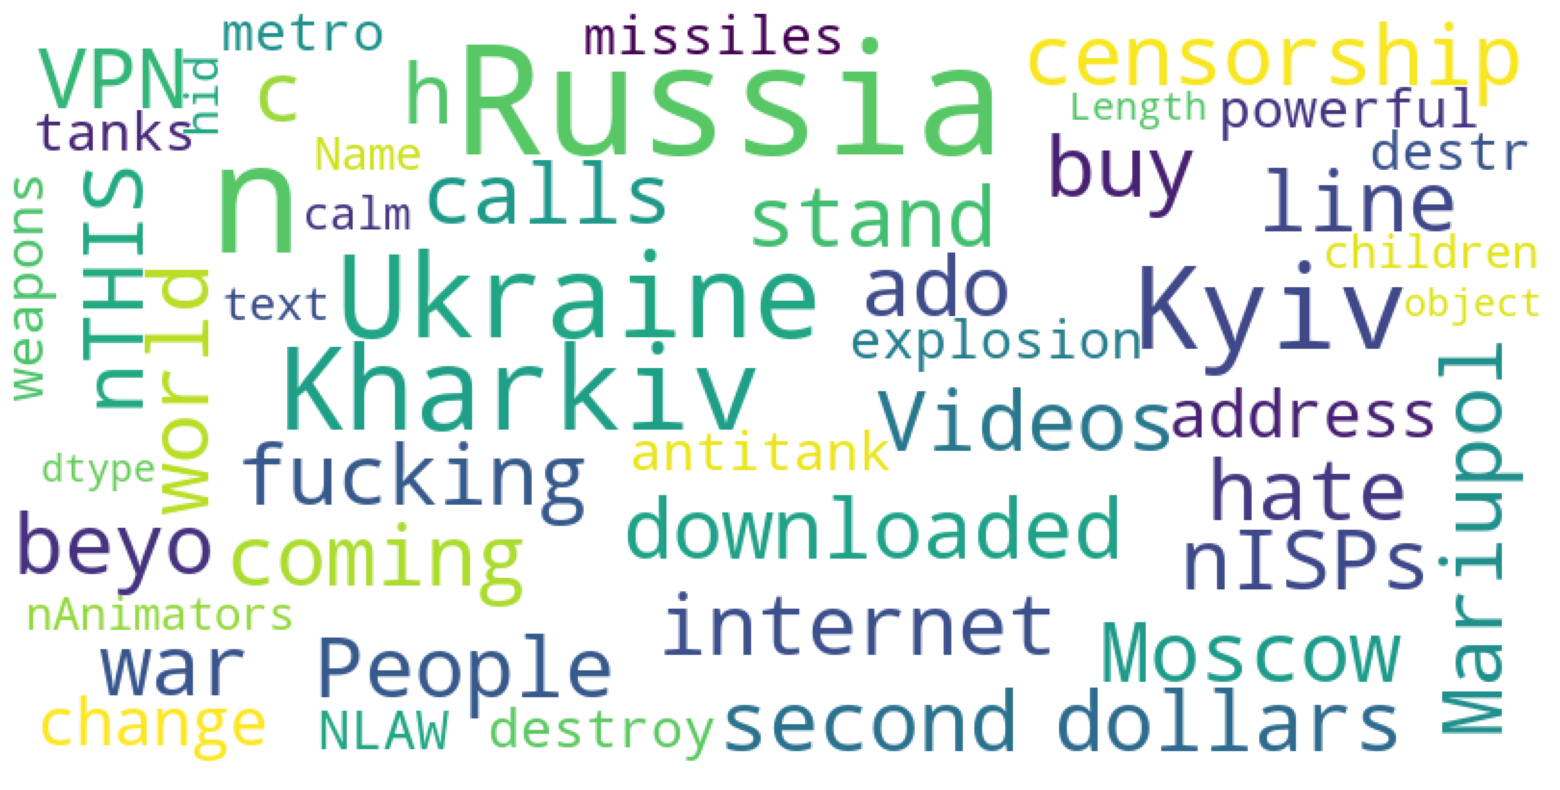

In [18]:
# Getting columns
columns = df_en.columns.to_list()

# Building word cloud
wordcloud = WordCloud(background_color='white',
                      stopwords=stopwords_set,
                      max_words=300,
                      max_font_size=40,
                      scale=2,
                      random_state=42
                     ).generate(str(sort_by_userage.iloc[:1000, columns.index('text')]))

# Displaying and saving word cloud
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('../static/newest_accounts_conversation_topics_wordcloud.png')
plt.show()

# Sentiment analysis


#### Note: due to computation limitations, we will be using only the first 10000 rows for demonstration purposes

In [123]:
# Building dataframe for sentiment analysis
sentiment_df = df_en[['text']].iloc[:10000]

sentiment_df.head()

text
1858647  #Putin has the 'nudes' of EU power house count...
1858648  Supermarkets removing #Russian food and drinks...
1858649  The war in #Ukraine is "a catastrophe" for the...
1858650  #OutlookBusiness | Exclusion of #Russian banks...
1858653  @Levitic67494072 @zenbarn21 @YaboiAliAS Did I?...

### We will be using RoBERTa for sentiment analysis
#### Note: we will be using the CPU as our local machine does not have an NVIDIA GPU

In [124]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [125]:
# Initializing tokenizer
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

# Initializing model
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment').to(device)

# Assigning sentiment labels
labels = ['negative', 'neutral', 'positive']

In [126]:
# Setting batch size
BATCH_SIZE = 10

# Getting sentiment scores for tweet texts
scores_all = np.empty((0, len(labels)))
text_all = sentiment_df['text'].to_list()
n = len(text_all)
with torch.no_grad():
    for start_idx in tqdm(range(0, n, BATCH_SIZE)):
        end_idx = min(start_idx + BATCH_SIZE, n)
        encoded_input = tokenizer(text_all[start_idx:end_idx], return_tensors='pt', padding=True, truncation=True).to(device)
        output = model(**encoded_input)
        scores = output[0].detach().cpu().numpy()
        scores = softmax(scores, axis=1)
        scores_all = np.concatenate((scores_all, scores), axis=0)
        del encoded_input, output, scores
        torch.cuda.empty_cache()

# Saving scores to sentiment dataframe
sentiment_df['negative'] = [i[0] for i in scores_all]
sentiment_df['neutral'] = [i[1] for i in scores_all]
sentiment_df['positive'] = [i[2] for i in scores_all]

100%|███████████████████████████████████████| 1000/1000 [06:24<00:00,  2.60it/s]


In [127]:
sentiment_df.head()

text  negative  \
1858647  #Putin has the 'nudes' of EU power house count...  0.498951   
1858648  Supermarkets removing #Russian food and drinks...  0.916419   
1858649  The war in #Ukraine is "a catastrophe" for the...  0.752255   
1858650  #OutlookBusiness | Exclusion of #Russian banks...  0.646272   
1858653  @Levitic67494072 @zenbarn21 @YaboiAliAS Did I?...  0.700084   

          neutral  positive  
1858647  0.470564  0.030485  
1858648  0.077905  0.005676  
1858649  0.231554  0.016191  
1858650  0.337932  0.015795  
1858653  0.280852  0.019064

# Emotion detection

In [128]:
# Initializing tokenizer
emotion_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")

# Initializing model
emotion_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion").to(device)

# Assigning sentiment labels
labels = ['anger', 'joy', 'optimism', 'sadness']

In [129]:
# Setting batch size
BATCH_SIZE = 10

# Getting emotion scores for tweet texts
scores_all = np.empty((0, len(labels)))
text_all = sentiment_df['text'].to_list()
n = len(text_all)
with torch.no_grad():
    for start_idx in tqdm(range(0, n, BATCH_SIZE)):
        end_idx = min(start_idx + BATCH_SIZE, n)
        encoded_input = tokenizer(text_all[start_idx:end_idx], return_tensors='pt', padding=True, truncation=True).to(device)
        output = emotion_model(**encoded_input)
        scores = output[0].detach().cpu().numpy()
        scores = softmax(scores, axis=1)
        scores_all = np.concatenate((scores_all, scores), axis=0)
        del encoded_input, output, scores
        torch.cuda.empty_cache()
    

# Saving scores to sentiment dataframe
sentiment_df['anger'] = [i[0] for i in scores_all]
sentiment_df['joy'] = [i[1] for i in scores_all]
sentiment_df['optimism'] = [i[2] for i in scores_all]
sentiment_df['sadness'] = [i[3] for i in scores_all]

100%|███████████████████████████████████████| 1000/1000 [06:31<00:00,  2.55it/s]


In [130]:
sentiment_df.head()

text  negative  \
1858647  #Putin has the 'nudes' of EU power house count...  0.498951   
1858648  Supermarkets removing #Russian food and drinks...  0.916419   
1858649  The war in #Ukraine is "a catastrophe" for the...  0.752255   
1858650  #OutlookBusiness | Exclusion of #Russian banks...  0.646272   
1858653  @Levitic67494072 @zenbarn21 @YaboiAliAS Did I?...  0.700084   

          neutral  positive     anger       joy  optimism   sadness  
1858647  0.470564  0.030485  0.805553  0.032517  0.096087  0.065843  
1858648  0.077905  0.005676  0.972835  0.004938  0.010430  0.011797  
1858649  0.231554  0.016191  0.193404  0.014840  0.123128  0.668628  
1858650  0.337932  0.015795  0.336791  0.016958  0.115551  0.530700  
1858653  0.280852  0.019064  0.934407  0.013377  0.021321  0.030895

In [131]:
# Saving all scores as a dataset
sentiment_df.to_csv("../data/output/roberta_scores.csv", index=False)

# Sentiment and emotion analysis 

## Sentiment analysis

In [132]:
# Reading previously generated RoBERTa scores
tweet_df = pd.read_csv("../data/output/roberta_scores.csv", lineterminator='\n')

tweet_df.head()

text  negative   neutral  \
0  #Putin has the 'nudes' of EU power house count...  0.498951  0.470564   
1  Supermarkets removing #Russian food and drinks...  0.916419  0.077905   
2  The war in #Ukraine is "a catastrophe" for the...  0.752255  0.231554   
3  #OutlookBusiness | Exclusion of #Russian banks...  0.646272  0.337932   
4  @Levitic67494072 @zenbarn21 @YaboiAliAS Did I?...  0.700084  0.280852   

   positive     anger       joy  optimism   sadness  
0  0.030485  0.805553  0.032517  0.096087  0.065843  
1  0.005676  0.972835  0.004938  0.010430  0.011797  
2  0.016191  0.193404  0.014840  0.123128  0.668628  
3  0.015795  0.336791  0.016958  0.115551  0.530700  
4  0.019064  0.934407  0.013377  0.021321  0.030895

In [133]:
# Adding a sentiment column to save overall sentiment
tweet_df.insert(4, "sentiment", '')

tweet_df.head(0)

Empty DataFrame
Columns: [text, negative, neutral, positive, sentiment, anger, joy, optimism, sadness]
Index: []

In [134]:
# Computing overall sentiment for each tweet
for i in range(len(tweet_df)):
  if tweet_df['negative'][i] > tweet_df['positive'][i] and tweet_df['negative'][i] > tweet_df['neutral'][i]:
    tweet_df['sentiment'][i] = 'negative'
  elif tweet_df['positive'][i] > tweet_df['negative'][i] and tweet_df['positive'][i] > tweet_df['neutral'][i]:
    tweet_df['sentiment'][i]= 'positive'
  else:
    tweet_df['sentiment'][i] = 'neutral'

tweet_df.head()

text  negative   neutral  \
0  #Putin has the 'nudes' of EU power house count...  0.498951  0.470564   
1  Supermarkets removing #Russian food and drinks...  0.916419  0.077905   
2  The war in #Ukraine is "a catastrophe" for the...  0.752255  0.231554   
3  #OutlookBusiness | Exclusion of #Russian banks...  0.646272  0.337932   
4  @Levitic67494072 @zenbarn21 @YaboiAliAS Did I?...  0.700084  0.280852   

   positive sentiment     anger       joy  optimism   sadness  
0  0.030485  negative  0.805553  0.032517  0.096087  0.065843  
1  0.005676  negative  0.972835  0.004938  0.010430  0.011797  
2  0.016191  negative  0.193404  0.014840  0.123128  0.668628  
3  0.015795  negative  0.336791  0.016958  0.115551  0.530700  
4  0.019064  negative  0.934407  0.013377  0.021321  0.030895

In [135]:
# Removing +ve, -ve, neutral columns as we don't need them anymore
tweet_df.drop(['negative','positive','neutral'], axis=1, inplace=True)

In [136]:
# Saving overall sentiments as a dataset
tweet_df.to_csv("../data/output/roberta_overall_sentiment.csv", index=False)

### Plot for overall sentiment of tweets

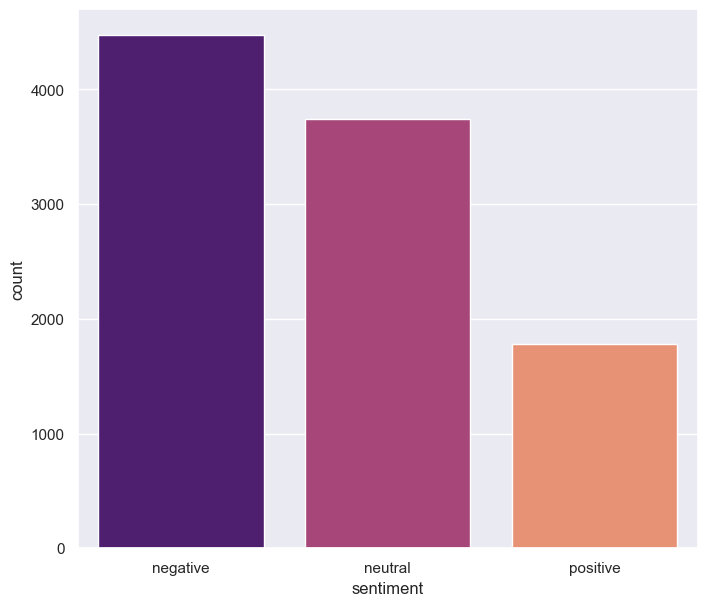

In [137]:
# Plotting barplot for visualization
plt.figure(figsize = (8,7))
fig = sns.countplot(x="sentiment", data=tweet_df, palette='magma')
fig = fig.get_figure()

# Saving barplot to file
fig.savefig('../static/overall_tweet_sentiment.png', bbox_inches='tight')

### Word cloud for negative, neutral and positive sentiments

In [139]:
tweet_neg = tweet_df.loc[tweet_df['sentiment']=='negative'].reset_index(drop=True)
tweet_net = tweet_df.loc[tweet_df['sentiment']=='neutral'].reset_index(drop=True)
tweet_pos = tweet_df.loc[tweet_df['sentiment']=='positive'].reset_index(drop=True)

#### Negative sentiment word cloud

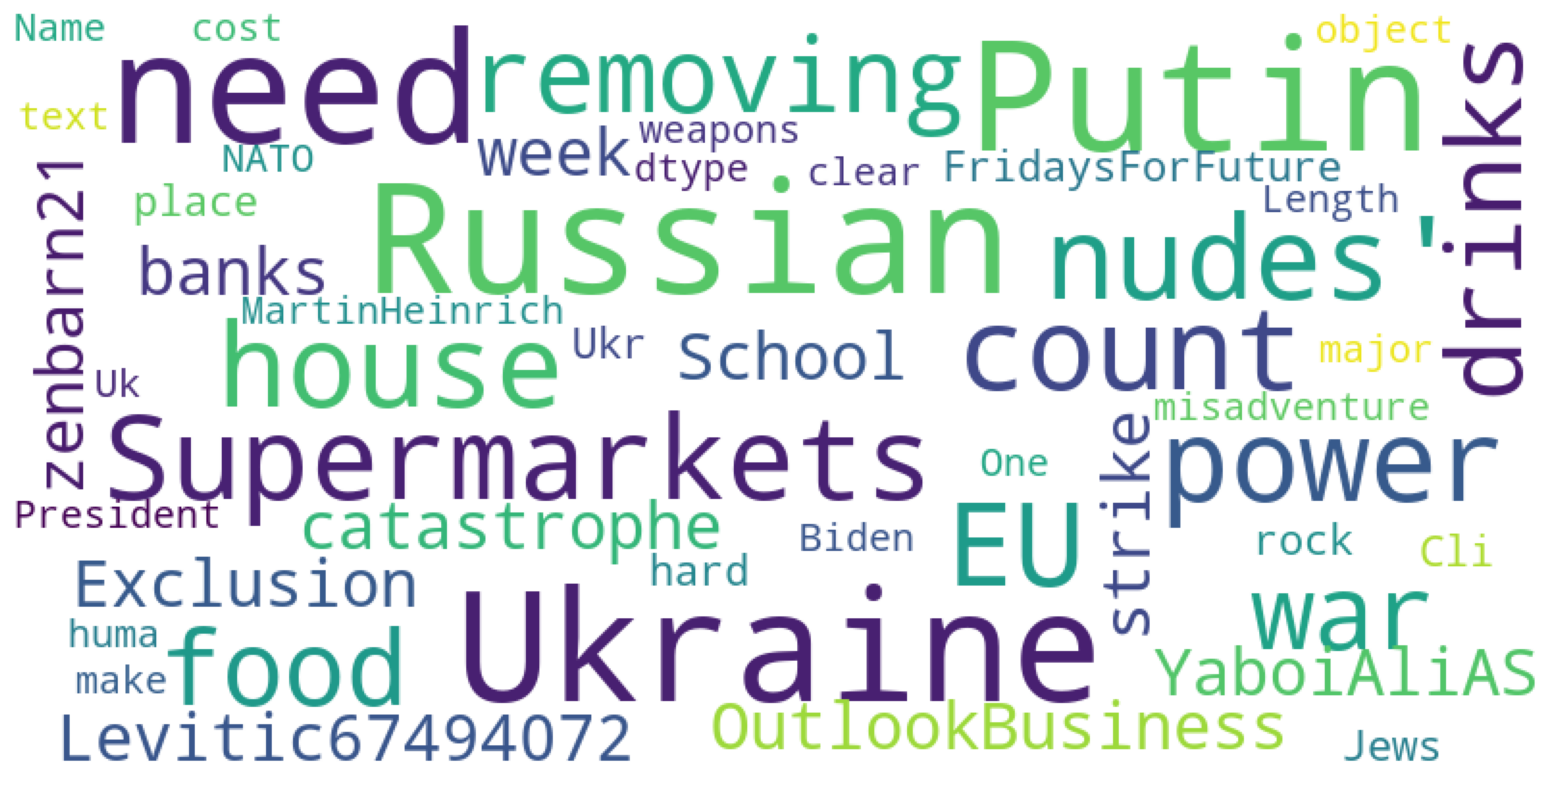

In [140]:
# Building word cloud
wordcloud = WordCloud(background_color='white',
                     stopwords = stopwords_set,
                      max_words = 300,
                      max_font_size = 40,
                      scale = 2,
                      random_state=42
                     ).generate(str(tweet_neg['text']))

# Displaying and saving word cloud
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('../static/negative_sentiment_wordcloud.png')
plt.show()

#### Neutral sentiment word cloud

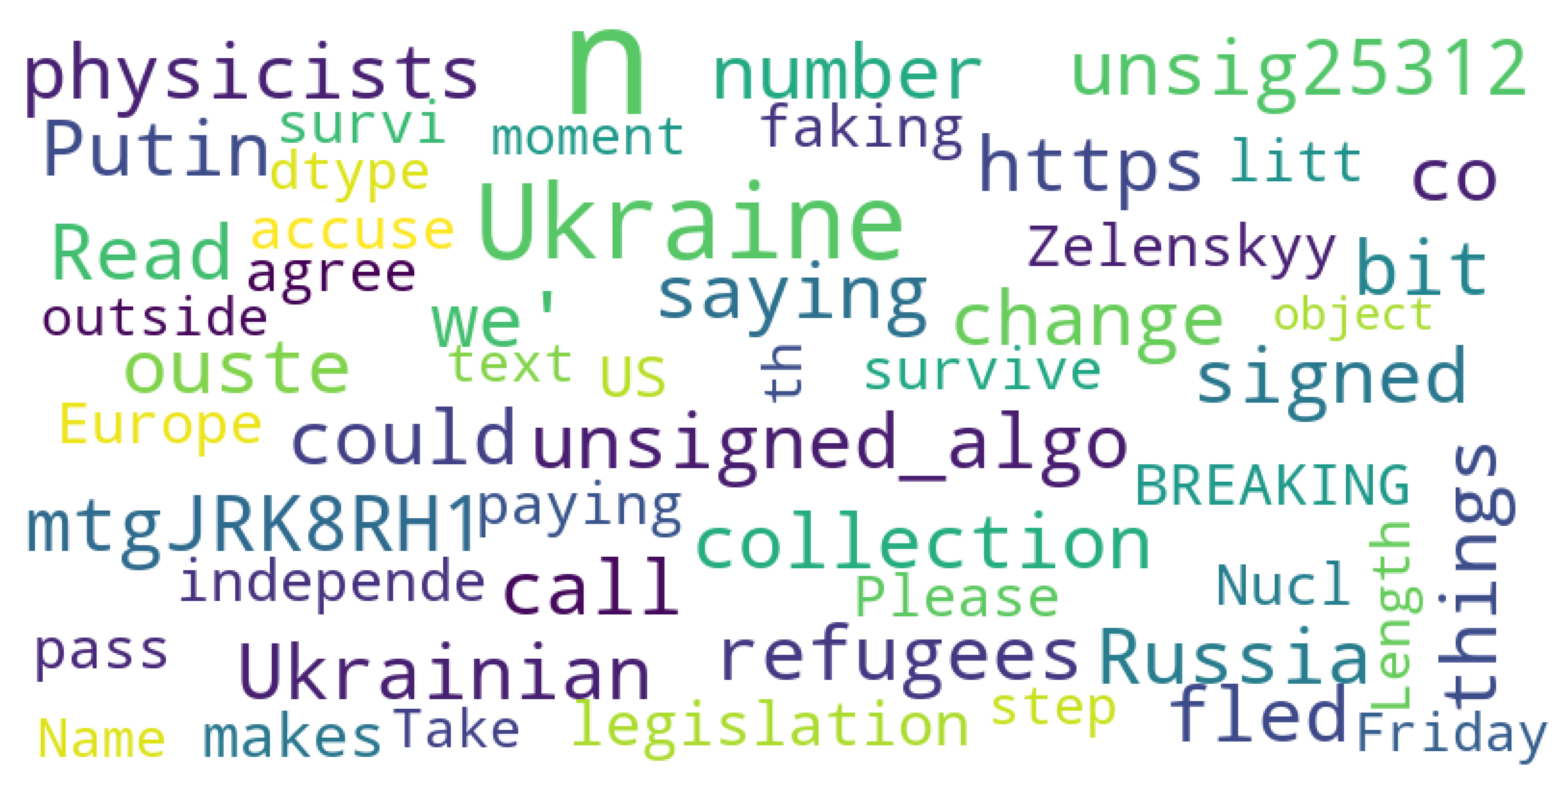

In [141]:
# Building word cloud
wordcloud = WordCloud(background_color='white',
                     stopwords = stopwords_set,
                      max_words = 300,
                      max_font_size = 40,
                      scale = 2,
                      random_state=42
                     ).generate(str(tweet_net['text']))

# Displaying and saving word cloud
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('../static/neutral_sentiment_wordcloud.png')
plt.show()

#### Positive sentiment word cloud

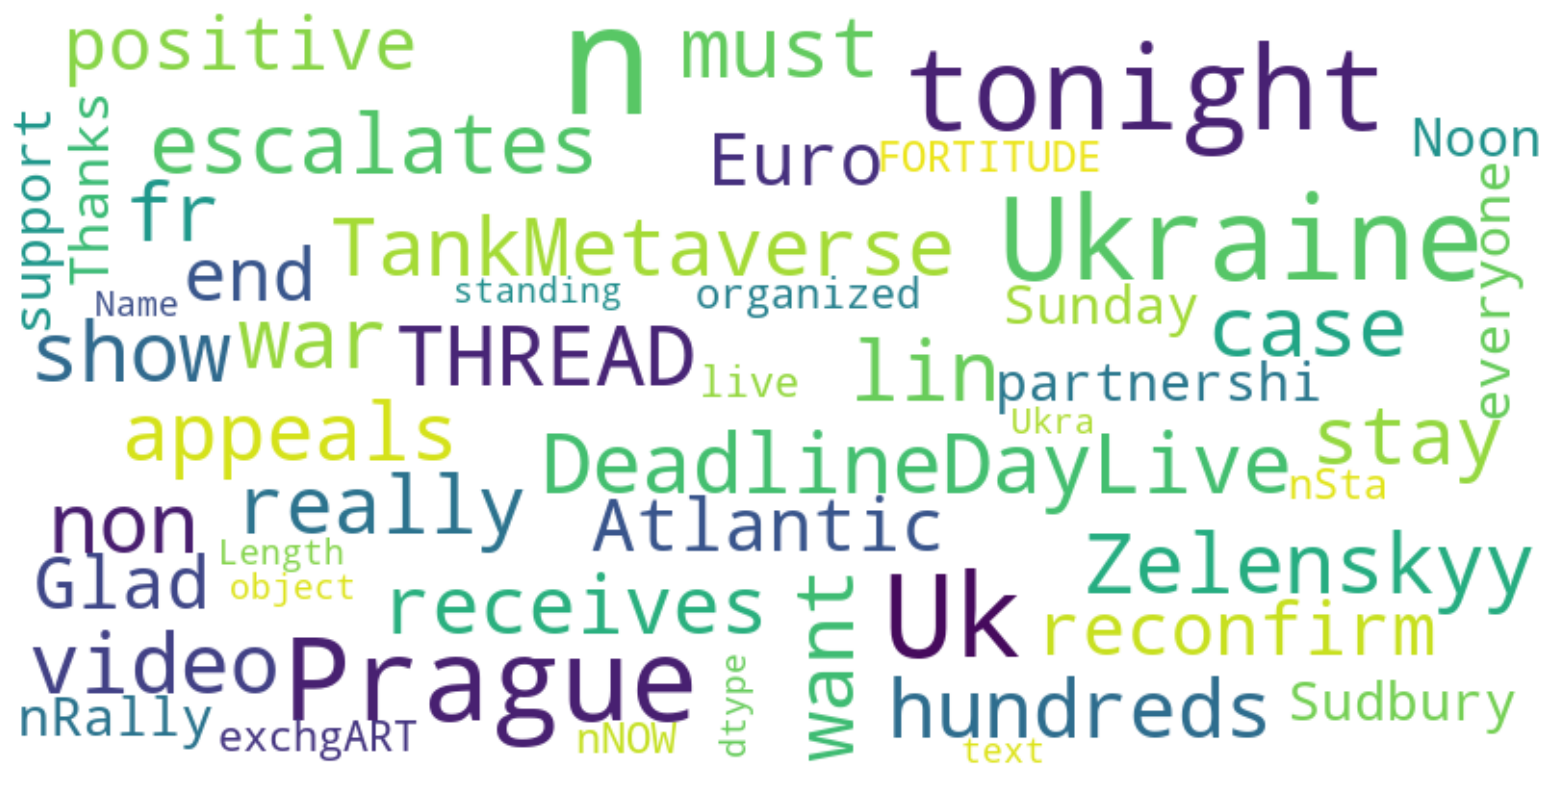

In [142]:
# Building word cloud
wordcloud = WordCloud(background_color='white',
                     stopwords = stopwords_set,
                      max_words = 300,
                      max_font_size = 40,
                      scale = 2,
                      random_state=42
                     ).generate(str(tweet_pos['text']))

# Displaying and saving word cloud
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('../static/positive_sentiment_wordcloud.png')
plt.show()

## Emotion analysis

In [172]:
# Reading previously generated RoBERTa scores
emotion_df = pd.read_csv("../data/output/roberta_scores.csv", lineterminator='\n')

emotion_df.head()

text  negative   neutral  \
0  #Putin has the 'nudes' of EU power house count...  0.498951  0.470564   
1  Supermarkets removing #Russian food and drinks...  0.916419  0.077905   
2  The war in #Ukraine is "a catastrophe" for the...  0.752255  0.231554   
3  #OutlookBusiness | Exclusion of #Russian banks...  0.646272  0.337932   
4  @Levitic67494072 @zenbarn21 @YaboiAliAS Did I?...  0.700084  0.280852   

   positive     anger       joy  optimism   sadness  
0  0.030485  0.805553  0.032517  0.096087  0.065843  
1  0.005676  0.972835  0.004938  0.010430  0.011797  
2  0.016191  0.193404  0.014840  0.123128  0.668628  
3  0.015795  0.336791  0.016958  0.115551  0.530700  
4  0.019064  0.934407  0.013377  0.021321  0.030895

In [173]:
# Removing +ve, -ve, neutral columns as we don't need them anymore
emotion_df.drop(['negative', 'positive', 'neutral'], axis=1, inplace=True)

# Adding a sentiment column to save overall sentiment
emotion_df.insert(5, "emotion", '')

emotion_df.head(0)

Empty DataFrame
Columns: [text, anger, joy, optimism, sadness, emotion]
Index: []

In [174]:
# Computing overall emotion for each tweet
for i in range(len(emotion_df)):
  if emotion_df['anger'][i] > emotion_df['joy'][i] and emotion_df['anger'][i] > emotion_df['optimism'][i] and emotion_df['anger'][i] > emotion_df['sadness'][i]:
    emotion_df['emotion'][i] = 'anger'
  elif emotion_df['joy'][i] > emotion_df['anger'][i] and emotion_df['joy'][i] > emotion_df['optimism'][i] and emotion_df['joy'][i] > emotion_df['sadness'][i]:
    emotion_df['emotion'][i]= 'joy'
  elif emotion_df['optimism'][i] > emotion_df['anger'][i] and emotion_df['optimism'][i] > emotion_df['joy'][i] and emotion_df['optimism'][i] > emotion_df['sadness'][i]:
    emotion_df['emotion'][i]= 'optimism'
  else:
    emotion_df['emotion'][i] = 'sadness'

emotion_df.head(10)

text     anger       joy  \
0  #Putin has the 'nudes' of EU power house count...  0.805553  0.032517   
1  Supermarkets removing #Russian food and drinks...  0.972835  0.004938   
2  The war in #Ukraine is "a catastrophe" for the...  0.193404  0.014840   
3  #OutlookBusiness | Exclusion of #Russian banks...  0.336791  0.016958   
4  @Levitic67494072 @zenbarn21 @YaboiAliAS Did I?...  0.934407  0.013377   
5  #Ukrainian physicists call for #Russia’s ouste...  0.237193  0.292514   
6  @DeadlineDayLive In which case, we must show s...  0.089180  0.408651   
7  The world leaders don't want to hear or talk a...  0.762540  0.008153   
8  (THREAD) As the war escalates in #Ukraine, non...  0.028713  0.043676   
9  Read: https://t.co/mtgJRK8RH1\n.\n.\n.\n.\n.\n...  0.105820  0.703406   

   optimism   sadness   emotion  
0  0.096087  0.065843     anger  
1  0.010430  0.011797     anger  
2  0.123128  0.668628   sadness  
3  0.115551  0.530700   sadness  
4  0.021321  0.030895     anger  
5  0.273715  0.196579       joy  
6  0.451051  0.051118  optimism  
7  0.094661  0.134646     anger  
8  0.857063  0.070547  optimism  
9  0.092325  0.098449       joy

In [175]:
# Removing +anger, joy, optimism, sadness columns as we don't need them anymore
emotion_df.drop(['anger','joy','optimism','sadness'], axis=1, inplace=True)

In [176]:
# Saving overall emotions as a dataset
emotion_df.to_csv("../data/output/roberta_overall_emotion.csv", index=False)

### Plot for overall emotion of tweets

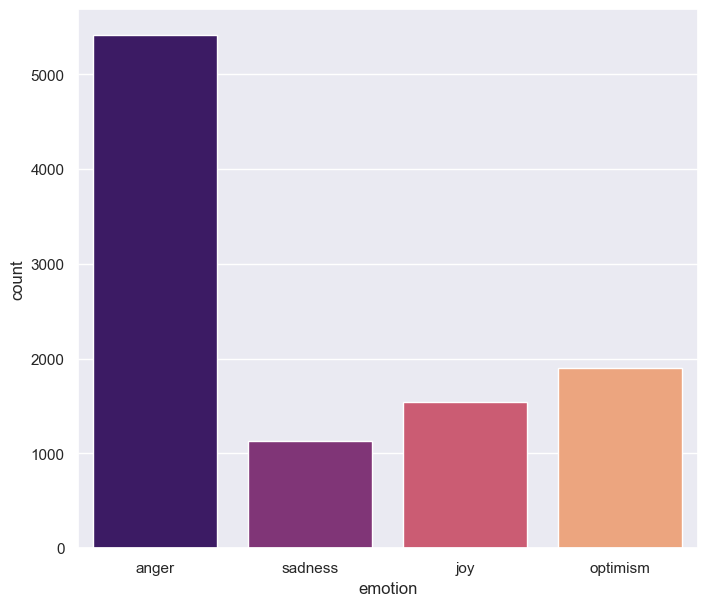

In [177]:
# Plotting barplot for visualization
plt.figure(figsize = (8,7))
fig = sns.countplot(x="emotion", data=emotion_df, palette='magma')
fig = fig.get_figure()

# Saving barplot to file
fig.savefig('../static/overall_tweet_emotion.png', bbox_inches='tight')

### Word cloud for anger, joy, optimism and sadness emotions

In [178]:
emotion_anger = emotion_df.loc[emotion_df['emotion']=='anger'].reset_index(drop=True)
emotion_joy = emotion_df.loc[emotion_df['emotion']=='joy'].reset_index(drop=True)
emotion_opt = emotion_df.loc[emotion_df['emotion']=='optimism'].reset_index(drop=True)
emotion_sad = emotion_df.loc[emotion_df['emotion']=='sadness'].reset_index(drop=True)

#### Anger emotion word cloud

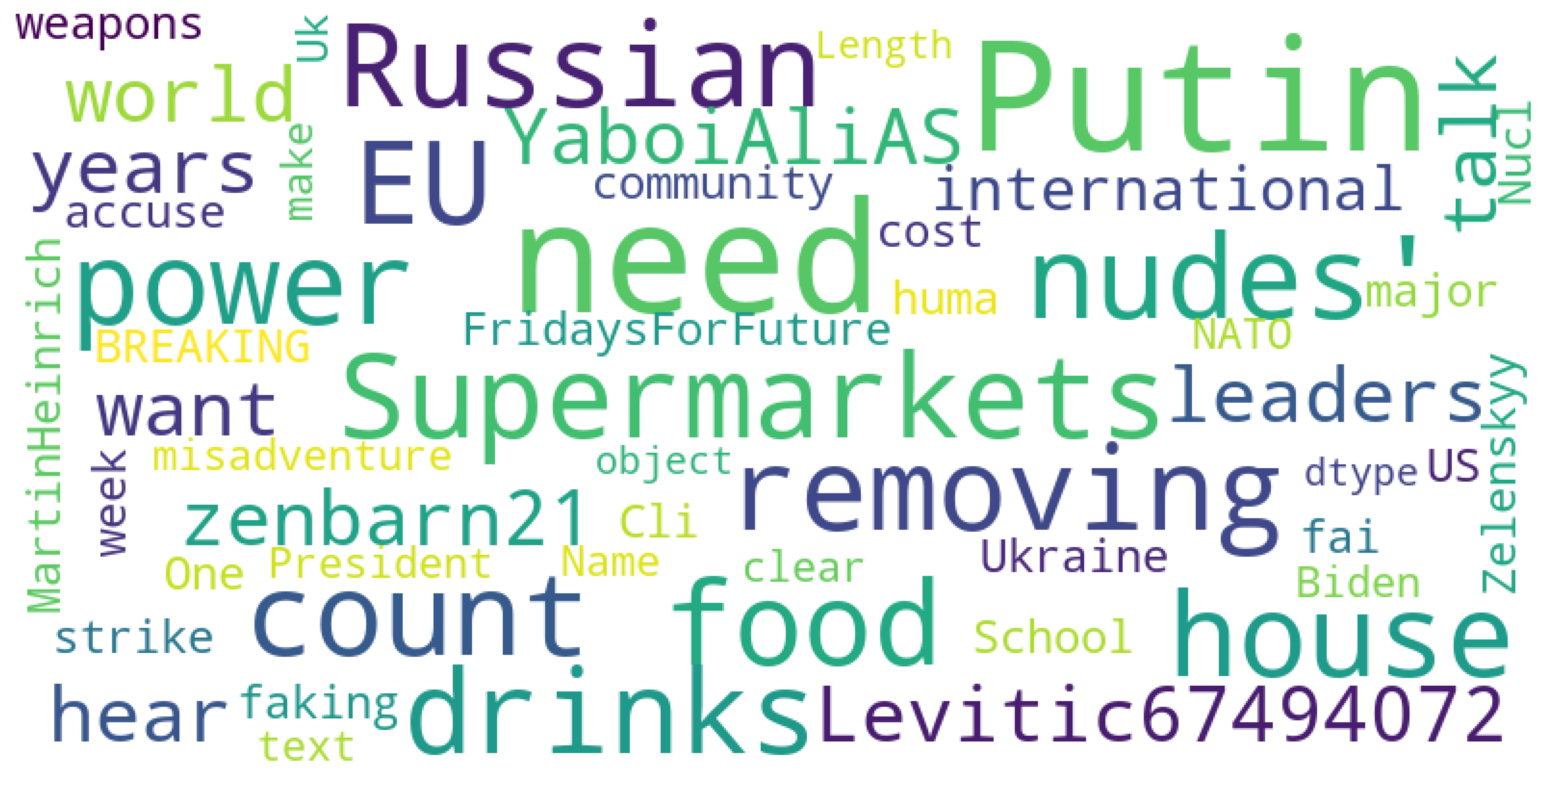

In [179]:
# Building word cloud
wordcloud = WordCloud(background_color='white',
                     stopwords = stopwords_set,
                      max_words = 300,
                      max_font_size = 40,
                      scale = 2,
                      random_state=42
                     ).generate(str(emotion_anger['text']))

# Displaying and saving word cloud
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('../static/anger_emotion_wordcloud.png')
plt.show()

#### Joy emotion word cloud

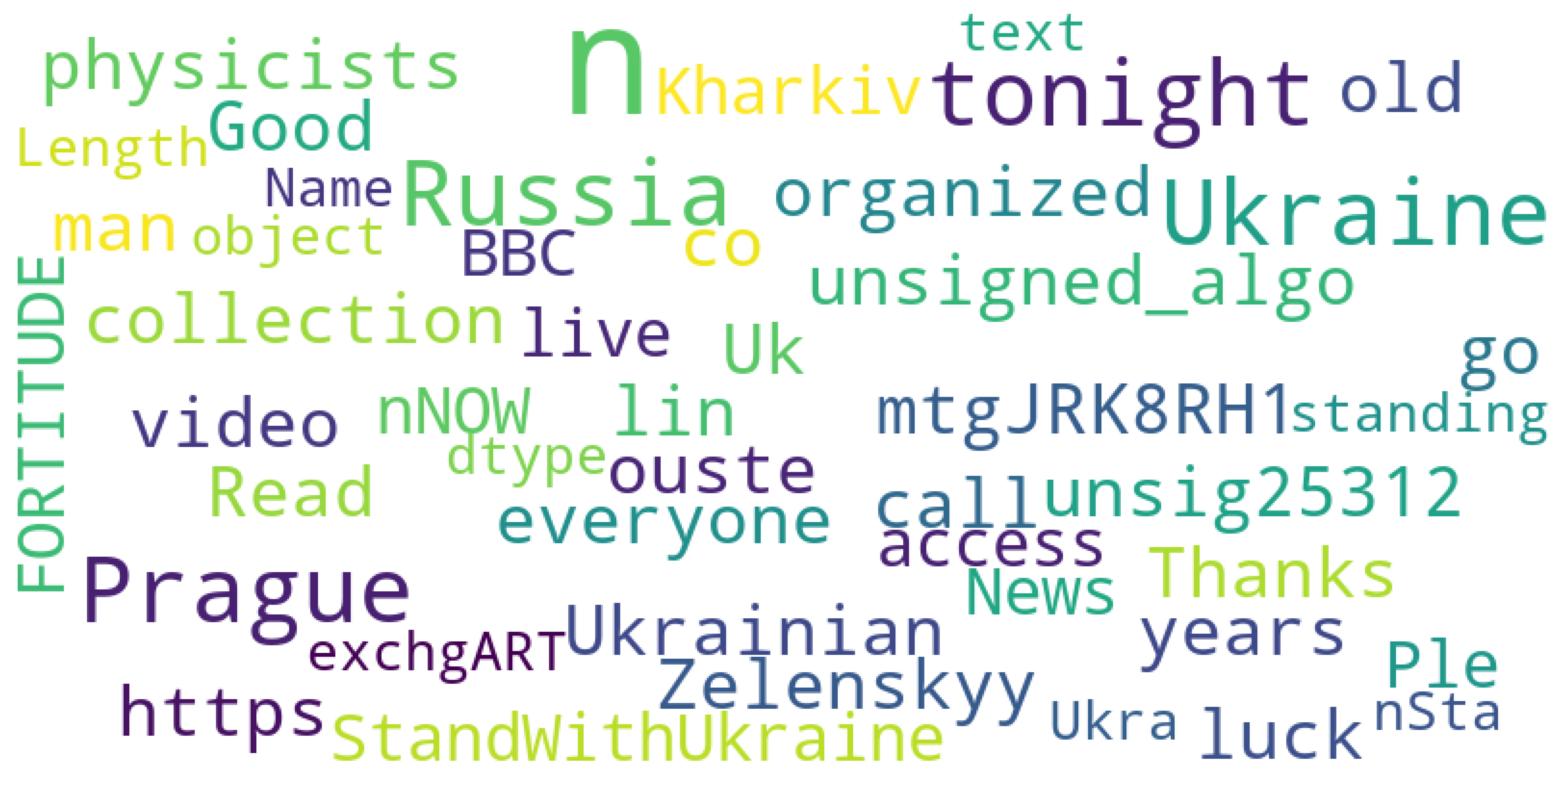

In [180]:
# Building word cloud
wordcloud = WordCloud(background_color='white',
                     stopwords = stopwords_set,
                      max_words = 300,
                      max_font_size = 40,
                      scale = 2,
                      random_state=42
                     ).generate(str(emotion_joy['text']))

# Displaying and saving word cloud
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('../static/joy_emotion_wordcloud.png')
plt.show()

#### Optimism emotion word cloud

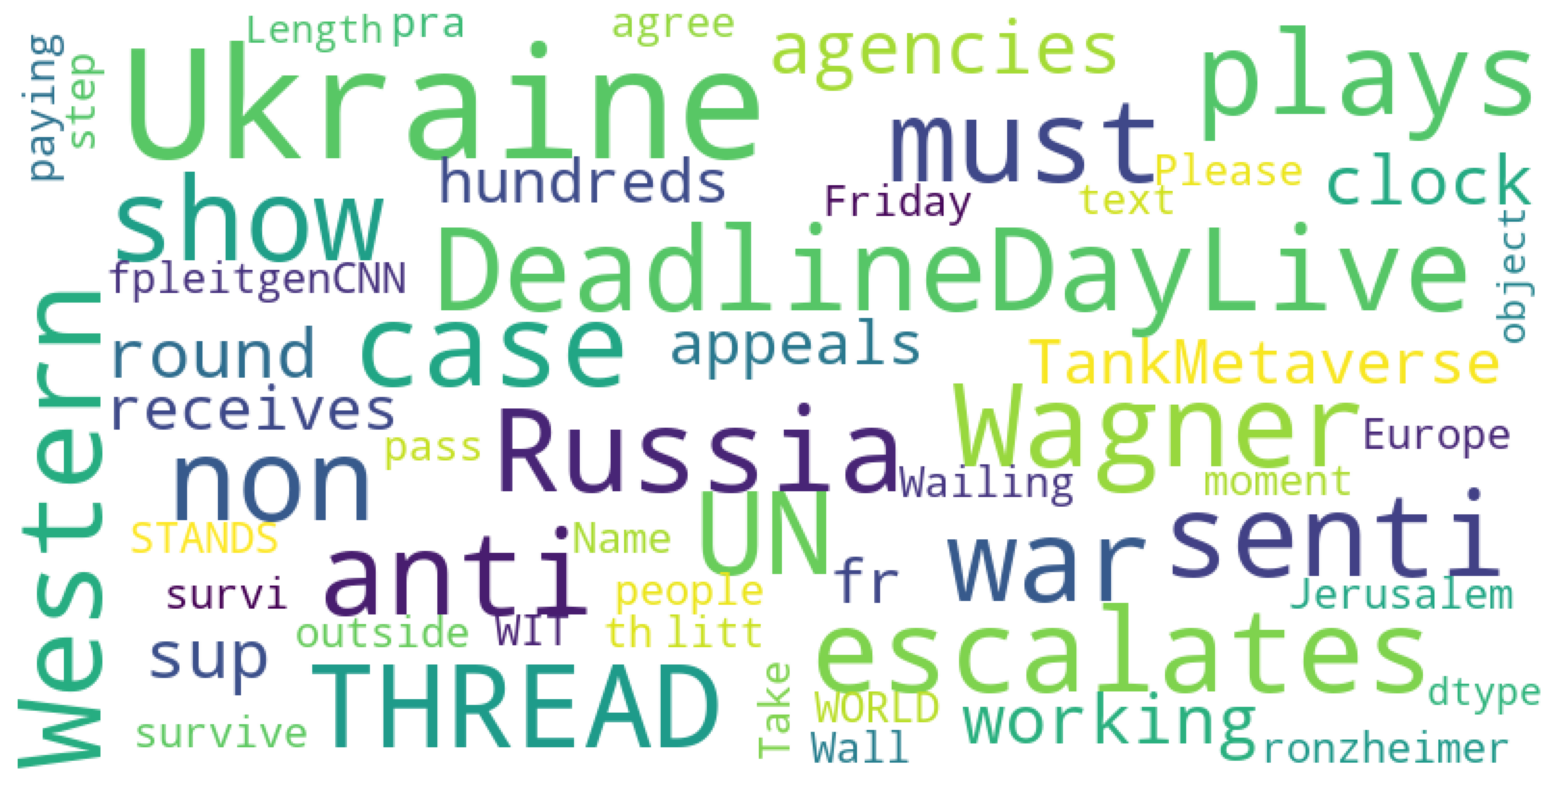

In [181]:
# Building word cloud
wordcloud = WordCloud(background_color='white',
                     stopwords = stopwords_set,
                      max_words = 300,
                      max_font_size = 40,
                      scale = 2,
                      random_state=42
                     ).generate(str(emotion_opt['text']))

# Displaying and saving word cloud
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('../static/optimism_emotion_wordcloud.png')
plt.show()

#### Sadness emotion word cloud

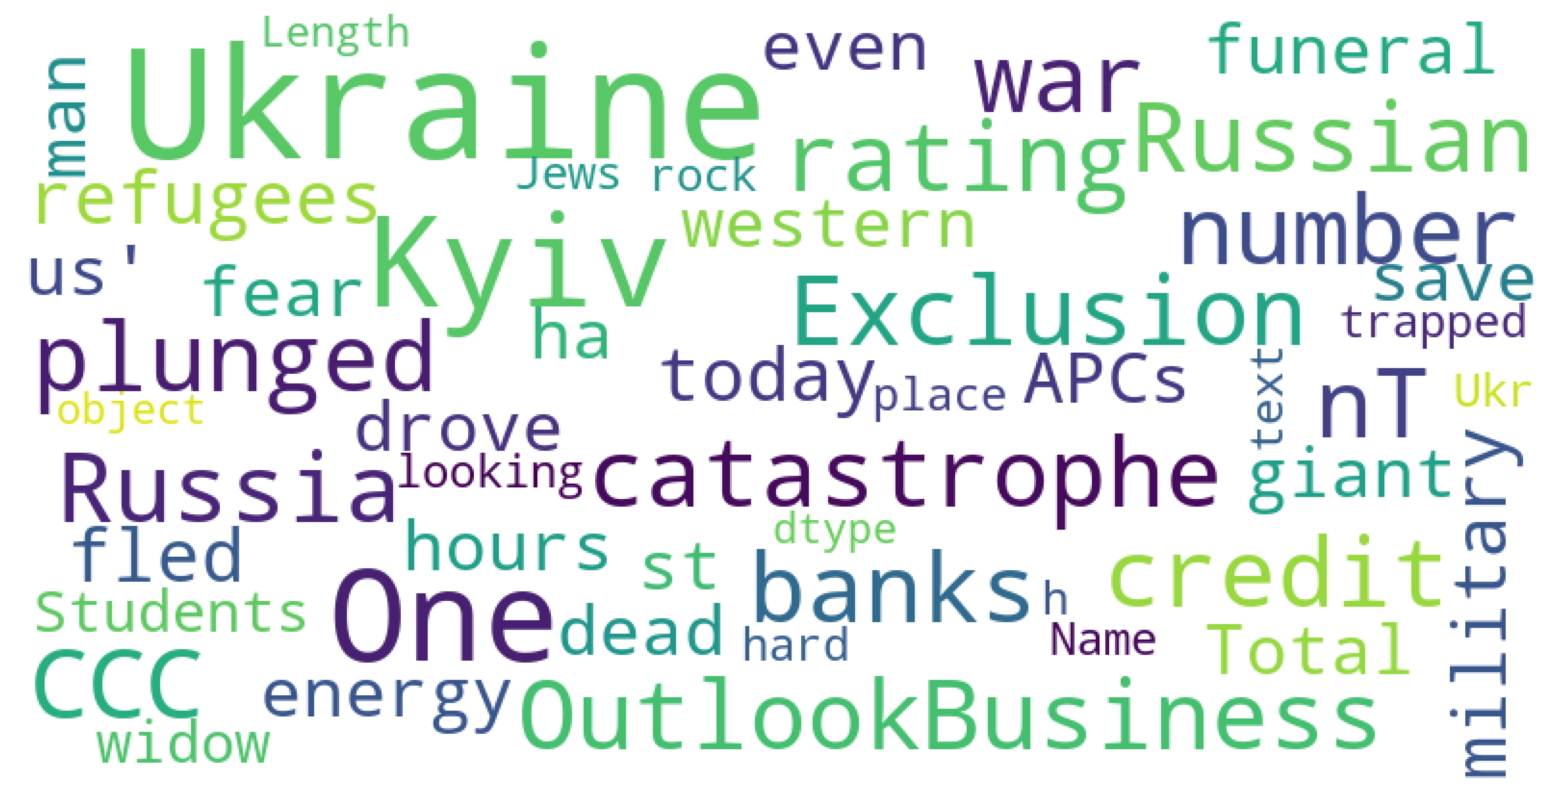

In [182]:
# Building word cloud
wordcloud = WordCloud(background_color='white',
                     stopwords = stopwords_set,
                      max_words = 300,
                      max_font_size = 40,
                      scale = 2,
                      random_state=42
                     ).generate(str(emotion_sad['text']))

# Displaying and saving word cloud
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('../static/sadness_emotion_wordcloud.png')
plt.show()